In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import optuna
from optuna.samplers import TPESampler

### Load data

In [ ]:
dataset = pd.read_parquet("/content/drive/MyDrive/projects/Поиск_одинаковых_товаров_на_маркетплейсе/extraction/hackathon_files_for_participants_ozon/train_pairs.parquet")
etl = pd.read_parquet("/content/drive/MyDrive/projects/Поиск_одинаковых_товаров_на_маркетплейсе/extraction/hackathon_files_for_participants_ozon/train_data.parquet")

In [ ]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [ ]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [ ]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Get raw data for each variantid.

In [ ]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [ ]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [ ]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [ ]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [ ]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

features[["pic_dist_0_perc_main", "pic_dist_25_perc_main", "pic_dist_50_perc_main"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

In [ ]:
features.sample(5)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main
221892,1.0,779737171,781146221,"Умные часы SKU00020, 45mm","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...","[черный, синий]","[[0.042556375, -0.4764188, 0.3653783, -0.09906...","[[-0.12030358, -0.4109926, 0.90287584, -0.4512...","[-0.6363881, 0.44219935, 0.42741245, -0.505532...","{""Форма циферблата"":[""Круглая""],""Цвет товара"":...",...,"[[0.042556375, -0.4764188, 0.3653783, -0.09906...","[[-0.12030358, -0.4109926, 0.90287584, -0.4512...","[-0.636388, 0.44219953, 0.42741257, -0.5055327...","{""Размер циферблата"":[""45mm""],""Образец цвета"":...",0.0,2.741372,3.924023,0.000000,0.000000,0.000000
221355,1.0,779116283,802660341,Картридж лазерный оригинальный Xerox 106R01633...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[желтый, yellow]","[[0.57190144, 0.7908616, 0.37428966, -0.262776...","[[0.2717871, 0.70065, 0.5067619, 0.06416737, 1...","[-0.57956946, 0.6944133, 0.58228433, -0.698960...","{""Тип"":[""Картридж""],""Ресурс"":[""1400""],""Комплек...",...,None,"[[0.23680982, 0.80628395, 0.5150241, 0.0198730...","[-0.5491894, 0.6941198, 0.53221905, -0.7244767...","{""Бренд"":[""Xerox""],""Назначение"":[""для лазерног...",-1.0,-1.000000,-1.000000,0.677385,0.677385,0.677385
156955,1.0,373279343,678060687,"Защитная пленка для дисплея Canon 3,2'' (4:3)","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Аксессу...",None,None,"[[-0.030141408, -0.073070146, 0.6989938, -0.06...","[-0.33360362, 0.6599892, 0.4122545, -0.5359199...","{""Гарантийный срок"":[""1 год""],""Тип"":[""Защита Ж...",...,None,"[[0.05758129, 0.03158231, 0.7841537, 0.0758529...","[-0.39300945, 0.66537505, 0.42792705, -0.52745...","{""Тип"":[""Защита ЖК-экрана""],""Бренд"":[""Canon""]}",-1.0,-1.000000,-1.000000,0.799377,0.799377,0.799377
293762,0.0,209829832,721676799,Картридж струйный CACTUS (CS-PFI107M) для CANO...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[-0.40368843, 0.7490759, 0.5792159, 0.2617752...","[-0.53984946, 0.5825006, 0.21325113, -0.534006...","{""Цвет тонера/чернил"":[""пурпурный""],""Тип"":[""Ка...",...,None,"[[-0.31796646, 0.9563299, 0.29357862, 0.160936...","[-0.41735864, 0.45081857, 0.1642356, -0.538695...","{""Тип"":[""Картридж""],""Бренд"":[""Mivis""],""Комплек...",-1.0,-1.000000,-1.000000,1.551870,1.551870,1.551870
142591,0.0,114636020,793658893,"15.6"" Ноутбук Acer A315-22-486A Aspire, AMD A4...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Компьют...","[black, черный]","[[0.7546103, -0.25686356, -0.5994239, -0.30438...","[[0.6700689, -0.32323962, -0.5261572, -0.22662...","[-0.6231954, 0.38059568, 0.56640315, -0.552037...","{""Цвет товара"":[""черный""],""Бренд"":[""Acer""],""Ве...",...,None,"[[0.5457429, -0.23669882, -0.49648613, -0.1760...","[-0.5793398, 0.42805576, 0.60690105, -0.557696...","{""Цвет товара"":[""черный""],""Бренд"":[""Acer""]}",-1.0,-1.000000,-1.000000,1.260700,1.260700,1.260700


In [ ]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [ ]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

In [ ]:
features.sample(5)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,characteristic_attributes_mapping2,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3
79693,0.0,811819600,811834037,Смартфон Google Pixel 4/Русифицирован/Поддержк...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",[оранжевый],"[[0.2101844, -0.57334787, 0.16825162, -0.76328...","[[0.5954076, -0.96224546, -0.12388612, -0.1317...","[-0.55702555, 0.3194873, 0.4629928, -0.1727611...","{""Модуль связи Bluetooth"":[""5.0""],""Встроенные ...",...,"{""Работа в режиме ожидания, ч"":[""133""],""Страна...",1.753997e-01,3.091352,5.057308,1.803977,1.803977,1.803977,0.000001,1.192093e-07,"Смартфоны, планшеты, мобильные телефоны"
265043,0.0,551531856,554263472,B75 8-карточная материнская плата для майнинга...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Электро...",[черный],"[[-1.2553282, -0.4204902, -0.4918356, -0.51092...","[[-0.76398873, -0.90504205, -0.19864535, -0.11...","[-0.60620743, 0.4855893, 0.5584577, -0.3486241...","{""Тип"":[""Активные компоненты""],""Бренд"":[""Нет б...",...,"{""Тип"":[""Органайзер для хранения проводов""],""С...",8.429370e-08,3.370255,3.677223,1.892682,1.892682,1.892682,0.606529,1.167411e-02,Электронные модули
300337,1.0,160771327,670158579,Клавиатура для ноутбука Samsung RV508,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Запчаст...",[черный],"[[0.7212224, 1.0599933, -1.6475616, 0.05077155...","[[0.15077364, 0.5900638, -1.4235299, 0.6461854...","[-0.63512796, 0.23381238, 0.41682947, -0.59654...","{""Тип"":[""Клавиатура для ноутбука""],""Рекомендов...",...,"{""Тип"":[""Клавиатура для ноутбука""],""Гарантийны...",-1.000000e+00,-1.000000,-1.000000,1.722918,1.722918,1.722918,0.522726,9.059906e-03,Запчасти для ноутбуков
59035,0.0,417983490,635731037,Комплект видеонаблюдения HIWATCH KIT 2N4M1 4 к...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Видеона...",[белый],"[[-0.083165705, -0.019598842, 0.27905613, -0.3...","[[0.03938864, 0.023834884, 0.030918404, 0.2961...","[-0.30029094, 0.50764877, 0.52503693, -0.37329...","{""Макс. температура эксплуатации, С°"":[""55""],""...",...,"{""Форматы файлов видео"":[""H.264""],""Угол обзора...",0.000000e+00,6.309557,7.589539,3.621898,3.621898,3.621898,0.333247,3.213346e-03,Видеонаблюдение
201406,0.0,92393105,372070632,Тонер-картридж ELP type MPC3503E (29500 стр.) ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[black, черный]",None,"[[0.7827438, 0.36260444, -0.36691827, -0.01188...","[-0.57513493, 0.6389794, 0.39868554, -0.453648...","{""Емкость"":[""Стандартная""],""Количество цветов""...",...,"{""Назначение"":[""для лазерного принтера""],""Цвет...",-1.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.408045,5.026698e-03,Расходник для печати


In [ ]:
cat3_counts

Let's find good cat size threshold

In [ ]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [ ]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [ ]:
features.sample(5)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped
56513,0.0,529620659,572273878,Пленка для ламинирования А4 OfficeSpace 216*30...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",None,"[[0.78704727, 0.4087522, -0.11457488, -0.57529...","[[-0.06978964, 0.91123897, -0.23626183, -0.149...","[-0.61218053, 0.56454605, 0.41898382, -0.70363...","{""Бренд"":[""Спейс""],""Страна-изготовитель"":[""Кит...",...,-1.000000,-1.000000,-1.000000,0.981991,0.981991,0.981991,0.453367,0.006852,Расходник для печати,Расходник для печати
90939,1.0,704016726,704038213,Смартфон Xiaomi Redmi Note 11 Pro 5G 8 128Gb E...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[белый, white]","[[0.076577105, -0.9963939, 0.86080337, -0.3179...","[[0.60622686, -0.9043145, 0.39071134, 0.141985...","[-0.5635931, 0.5016343, 0.46372053, -0.3850720...","{""Тип"":[""Смартфон""],""Беспроводные интерфейсы"":...",...,0.000000,1.554795,6.296021,1.489392,1.489392,1.489392,0.346735,0.003546,"Смартфоны, планшеты, мобильные телефоны","Смартфоны, планшеты, мобильные телефоны"
232886,0.0,607391130,680367455,"Смартфон Samsung Galaxy A52 8/128 ГБ, черный","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",[черный],"[[0.33832368, -0.98018605, 0.40783486, -0.6160...","[[0.041387893, -1.1060137, 0.36124924, 0.33861...","[-0.49218494, 0.46165824, 0.5125708, -0.507550...","{""Модуль связи WiFi"":[""802.11a/b/g/n"",""802.11a...",...,3.032904,6.316775,6.910548,0.770236,0.770236,0.770236,0.273328,0.002347,"Смартфоны, планшеты, мобильные телефоны","Смартфоны, планшеты, мобильные телефоны"
65872,0.0,523587320,621416659,"15.6"" Ноутбук Acer Extensa 15 EX215-22G-R6EN, ...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Компьют...",[черный],"[[0.9044281, -0.44627166, -0.8310489, -0.55383...","[[0.9099434, -0.5480257, -0.91129947, -0.70539...","[-0.45454842, 0.2674207, 0.65827554, -0.632757...","{""Общий объем SSD, ГБ"":[""256""],""Разрешение Web...",...,-1.000000,-1.000000,-1.000000,0.960368,0.960368,0.960368,0.643289,0.011589,Компьютер,Компьютер
243117,0.0,516570887,516572081,Электронный модуль,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Электро...",None,"[[0.17397961, -0.5262574, 0.1932903, 0.3626129...","[[0.38226414, -0.17578857, 0.17272559, 0.55344...","[-0.6474362, 0.7381374, 0.32933205, -0.3361843...","{""Гарантийный срок"":[""14 дней""],""Тип"":[""Электр...",...,4.966882,4.966882,4.966882,3.636138,3.636138,3.636138,0.000000,0.000000,Электронные модули,Электронные модули


Choose features

In [ ]:
# added main pictures and cat3
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 'pic_dist_0_perc_main', 
         'pic_dist_25_perc_main', 'pic_dist_50_perc_main',
         "euclidean_name_bert_dist", "cosine_name_bert_dist", 'cat3']

In [ ]:
def cat_preprocessing(df, col):
  label_encoder = preprocessing.LabelEncoder()
  df[col]= label_encoder.fit_transform(df[col])
  return df

In [ ]:
features = cat_preprocessing(features, 'cat3')

In [ ]:
features.head()

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,-1.0,-1.0,-1.0,0.259265,0.259265,0.259265,0.338458,0.003606,60,"Сетевые фильтры, разветвители и удлинители"
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,-1.0,-1.0,-1.0,0.282023,0.282023,0.282023,0.475419,0.007311,60,"Сетевые фильтры, разветвители и удлинители"
2,1.0,53062686,536165289,Картридж лазерный Комус 729 (4370B002) черный ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.0032773763, 0.32531193, -0.33156675, 0.41...","[-0.53706163, 0.37264067, 0.44363657, -0.37289...","{""Количество в упаковке, шт"":[""1""],""Бренд"":[""К...",...,-1.0,-1.0,-1.0,1.078670,1.078670,1.078670,0.577868,0.010588,54,Расходник для печати
3,1.0,53602615,587809782,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,-1.0,-1.0,-1.0,1.008816,1.008816,1.008816,0.491225,0.007455,54,Расходник для печати
4,1.0,53602615,615149925,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,-1.0,-1.0,-1.0,0.985881,0.985881,0.985881,0.451149,0.006258,54,Расходник для печати


Split dataset

In [ ]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)

In [ ]:
X_train = X_train[feats]
X_val = X_val[feats]

In [ ]:
X_train.head()

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3
68341,-1.0,-1.000000,-1.000000,1.868696,1.868696,1.868696,0.412746,0.004632,63
187573,0.0,3.834663,5.543013,0.000000,0.000000,0.000000,0.377481,0.003956,77
157454,-1.0,-1.000000,-1.000000,1.794320,1.794320,1.794320,0.591899,0.010588,32
16957,-1.0,-1.000000,-1.000000,1.712504,1.712504,1.712504,0.408357,0.004789,29
270799,-1.0,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.479424,0.006767,32


In [ ]:
X_val.head()

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3
251123,1.192093e-07,1.194890,2.389780,0.000000,0.000000,0.000000,0.444985,0.005992,72
146897,-1.000000e+00,-1.000000,-1.000000,3.148793,3.148793,3.148793,0.381131,0.004967,9
266240,1.863044e-02,0.200757,6.951036,0.179071,0.179071,0.179071,0.459749,0.006570,46
15326,0.000000e+00,3.419297,4.530387,0.000000,0.000000,0.000000,0.400961,0.004886,35
136472,-1.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.493874,0.007640,77


In [ ]:
X_test.head()

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,variantid1,variantid2,cat3_grouped
305957,-1.000000,-1.000000,-1.000000,2.512714,2.512714,2.512714,0.284204,0.002250,9,506029509,759875352,Батарейки и аккумуляторы
221201,1.102281,3.954101,6.468230,2.478776,2.478776,2.478776,0.330778,0.002966,12,631006367,634594177,Видеокарты и графические ускорители
195270,-1.000000,-1.000000,-1.000000,3.852654,3.852654,3.852654,0.000000,0.000000,26,670055184,670056907,Зарядные устройства и док-станции
287427,0.000000,4.719967,5.439224,0.000000,0.000000,0.000000,0.411536,0.005129,63,777611929,777634742,"Смартфоны, планшеты, мобильные телефоны"
45851,0.000000,5.754701,6.402929,0.000000,0.000000,0.000000,0.450884,0.006095,62,754490943,788620991,Смарт-часы


Optuna

In [ ]:
def catboost_clf_objective(trial):

  model = CatBoostClassifier(
      task_type=trial.suggest_categorical('task_type', ['GPU']),
      iterations=trial.suggest_int('iterations', 400, 1000),
      learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
      depth=trial.suggest_int('depth', 5, 15),
      l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 3.0, 30.0, log=True),
      bootstrap_type=trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
      verbose=False
  )

  model.fit(X_train, y_train)
  
  y_pred = model.predict(X_val)

  return accuracy_score(y_val, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name='catboost', direction='maximize', sampler=sampler)
study.optimize(catboost_clf_objective, n_trials=10)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
Value:  0.7744753343723948
Params: 
    task_type: GPU
    iterations: 926
    learning_rate: 0.06154791240242939
    depth: 5
    l2_leaf_reg: 3.282283109923531
    bootstrap_type: Bernoulli


In [ ]:
model = CatBoostClassifier(**trial.params, verbose=True)
model.fit(X_train, y_train)

0:	learn: 0.6797890	total: 8.23ms	remaining: 7.62s
1:	learn: 0.6686259	total: 15.6ms	remaining: 7.2s
2:	learn: 0.6590657	total: 22.7ms	remaining: 6.99s
3:	learn: 0.6508284	total: 29.9ms	remaining: 6.89s
4:	learn: 0.6439151	total: 36.9ms	remaining: 6.8s
5:	learn: 0.6375715	total: 43.9ms	remaining: 6.74s
6:	learn: 0.6313244	total: 51.2ms	remaining: 6.72s
7:	learn: 0.6264307	total: 58.3ms	remaining: 6.69s
8:	learn: 0.6213638	total: 65.5ms	remaining: 6.67s
9:	learn: 0.6162924	total: 72.6ms	remaining: 6.65s
10:	learn: 0.6102246	total: 79.9ms	remaining: 6.65s
11:	learn: 0.6049455	total: 87.2ms	remaining: 6.64s
12:	learn: 0.5999752	total: 94.4ms	remaining: 6.63s
13:	learn: 0.5958022	total: 102ms	remaining: 6.62s
14:	learn: 0.5924876	total: 109ms	remaining: 6.6s
15:	learn: 0.5886698	total: 116ms	remaining: 6.6s
16:	learn: 0.5858652	total: 123ms	remaining: 6.58s
17:	learn: 0.5823779	total: 130ms	remaining: 6.56s
18:	learn: 0.5795132	total: 137ms	remaining: 6.55s
19:	learn: 0.5776654	total: 144m

In [ ]:
model.save_model(f"/content/drive/MyDrive/projects/Поиск_одинаковых_товаров_на_маркетплейсе/baseline_optuna_v3.cbm")

### Metric

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [ ]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [ ]:
X_test

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,variantid1,variantid2,cat3_grouped,scores
305957,-1.000000,-1.000000,-1.000000,2.512714,2.512714,2.512714,0.284204,0.002250,9,506029509,759875352,Батарейки и аккумуляторы,0.768697
221201,1.102281,3.954101,6.468230,2.478776,2.478776,2.478776,0.330778,0.002966,12,631006367,634594177,Видеокарты и графические ускорители,0.731001
195270,-1.000000,-1.000000,-1.000000,3.852654,3.852654,3.852654,0.000000,0.000000,26,670055184,670056907,Зарядные устройства и док-станции,0.539419
287427,0.000000,4.719967,5.439224,0.000000,0.000000,0.000000,0.411536,0.005129,63,777611929,777634742,"Смартфоны, планшеты, мобильные телефоны",0.049148
45851,0.000000,5.754701,6.402929,0.000000,0.000000,0.000000,0.450884,0.006095,62,754490943,788620991,Смарт-часы,0.821587
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53761,2.054667,3.743674,4.581620,2.465810,2.465810,2.465810,0.000000,0.000000,30,734748080,792954282,Игровая приставка,0.984947
15348,0.000000,5.244668,6.187644,1.253254,1.253254,1.253254,0.413376,0.005513,63,705810210,766959829,"Смартфоны, планшеты, мобильные телефоны",0.138412
72442,1.650580,2.087682,3.832118,2.419211,2.419211,2.419211,0.000000,0.000000,7,291912252,607136713,Акустика и колонки,0.976679
302220,1.118870,2.197096,3.281416,1.651057,1.651057,1.651057,0.689269,0.015525,21,92458254,472163157,"Жесткие диски, SSD и сетевые накопители",0.613927


In [ ]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.4243962513781794

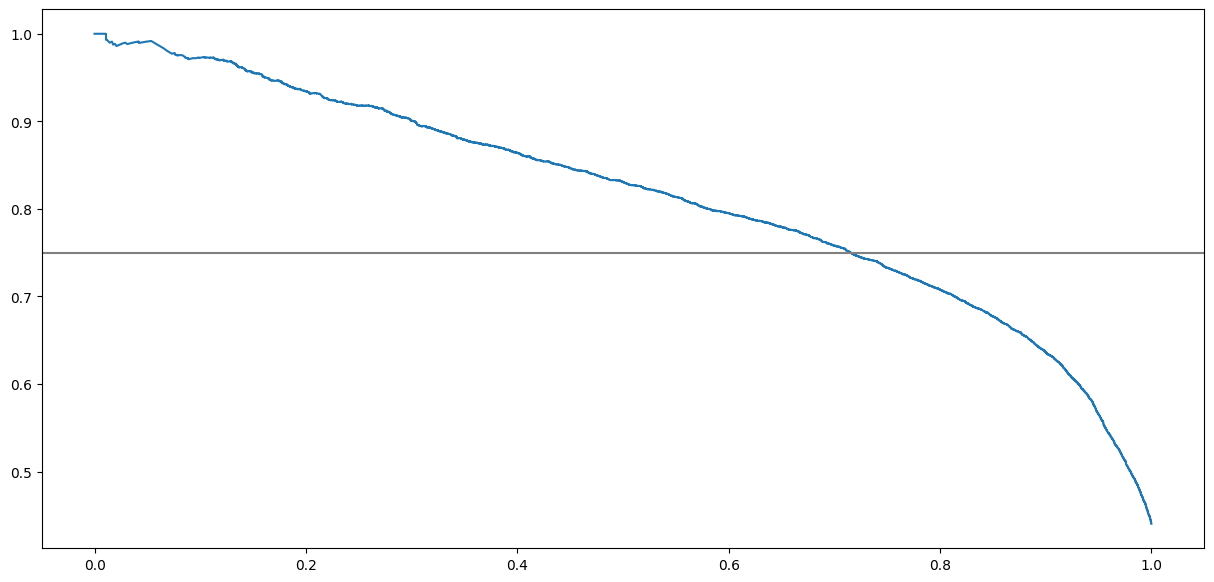

In [ ]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');